<a href="https://colab.research.google.com/github/mannixp/PDF_Equation/blob/main/ABC_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook applies the forward Kolmogorov equation derived in *Craske J. et al. 2024* to the case of a scalar concentration evolving subject to an advection diffusion equation in a triply peridioc domain. The advection diffusion equation is solved using the open source pseudo-spectral code [Dedalus](https://dedalus-project.org/) (*Burns K.J. et. al. 2020*), while the relevant terms in the forward Kolmogorov equation are estimated using histograms.


**Setup**

This cell checks if Dedalus is installed and performs some other basic setup.


In [ ]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install --no-cache http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archiv


**Content**

First let's import everything we need to run the rest of the notebook.


In [ ]:
import numpy as np
import dedalus.public as d3
import logging
import h5py
logger = logging.getLogger(__name__)

Next we solve the equation for the scalar concentration
\begin{equation}
\partial_t S + \left( \boldsymbol{U} \cdot \nabla \right) S = \kappa \nabla^2 S,
\end{equation}
over the time interval $t \in [0,1]$ in a triply-periodic box $\Pi^3$, with the velocity field given by the so called ABC flow
\begin{equation}
 \boldsymbol{U} = \left( A \sin(z) + C \cos(y), B \sin(x) + A \cos(z),  C \sin(y) + B \cos(x) \right).
\end{equation}
As an initial condition we prescribe a sharp interface,
\begin{equation}
S(\boldsymbol{x},t=0) = \tanh(10\boldsymbol{x}).
\end{equation}
*NOTE: This takes about 3 minutes to run.*

In [ ]:
# Parameters
κ     = 0.1;  # Equivalent to Peclet number
A,B,C = 1,1,1;
Nx    = 48;   # This can be reduced but it will increase the noise in the histogram
stop_sim_time = 1
timestep = 1e-03

# Domain
coords = d3.CartesianCoordinates('x','y','z')
dist   = d3.Distributor(coords, dtype=np.float64)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(-np.pi, np.pi), dealias=3/2)
ybasis = d3.RealFourier(coords['y'], size=Nx, bounds=(-np.pi, np.pi), dealias=3/2)
zbasis = d3.RealFourier(coords['z'], size=Nx, bounds=(-np.pi, np.pi), dealias=3/2)

# Fields
S = dist.Field(name='S', bases=(xbasis,ybasis,zbasis))
U = dist.VectorField(coords, name='U', bases=(xbasis,ybasis,zbasis))
x,y,z = dist.local_grids(xbasis,ybasis,zbasis)

# ABC flow
U['g'][0] = A*np.sin(z) + C*np.cos(y);
U['g'][1] = B*np.sin(x) + A*np.cos(z);
U['g'][2] = C*np.sin(y) + B*np.cos(x);

# Initial condition
S['g']    = np.tanh(10*(x + y + z))

# Problem
grad_S  = d3.grad(S)
problem = d3.IVP([S], namespace=locals())
problem.add_equation("dt(S) - κ*div(grad_S) = -U@grad(S)") #

# Solver
solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = stop_sim_time

# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=100)
flow.add_property(d3.Integrate(S**2)         , name='<S^2>' )
flow.add_property(d3.Integrate(grad_S@grad_S), name='<dS^2>')

# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 100 == 0:

            S2_avg = flow.grid_average('<S^2>')
            dS_avg = flow.grid_average('<dS^2>' )

            logger.info('Iteration=%i, Time=%e, dt=%e'%(solver.iteration, solver.sim_time, timestep))
            logger.info('<S^2>=%f, <dS^2>    =%f'%(S2_avg,dS_avg))

        # Capture the last 5 snapshots
        if  solver.iteration == int(stop_sim_time/timestep) - 5:
            snapshots = solver.evaluator.add_file_handler('snapshots', iter=1)
            snapshots.add_task(S,      layout='g',name='Scalar',scales=3/2)
            snapshots.add_task(grad_S, layout='g',name='grad_S',scales=3/2)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

INFO:subsystems:Building subproblem matrices 1/256 (~0%) Elapsed: 0s, Remaining: 10s, Rate: 2.6e+01/s


2024-04-18 12:47:19,802 subsystems 0/1 INFO :: Building subproblem matrices 1/256 (~0%) Elapsed: 0s, Remaining: 10s, Rate: 2.6e+01/s


INFO:subsystems:Building subproblem matrices 26/256 (~10%) Elapsed: 1s, Remaining: 6s, Rate: 3.7e+01/s


2024-04-18 12:47:20,457 subsystems 0/1 INFO :: Building subproblem matrices 26/256 (~10%) Elapsed: 1s, Remaining: 6s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 52/256 (~20%) Elapsed: 1s, Remaining: 6s, Rate: 3.6e+01/s


2024-04-18 12:47:21,193 subsystems 0/1 INFO :: Building subproblem matrices 52/256 (~20%) Elapsed: 1s, Remaining: 6s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 78/256 (~30%) Elapsed: 2s, Remaining: 4s, Rate: 4.0e+01/s


2024-04-18 12:47:21,700 subsystems 0/1 INFO :: Building subproblem matrices 78/256 (~30%) Elapsed: 2s, Remaining: 4s, Rate: 4.0e+01/s


INFO:subsystems:Building subproblem matrices 104/256 (~41%) Elapsed: 2s, Remaining: 3s, Rate: 4.4e+01/s


2024-04-18 12:47:22,118 subsystems 0/1 INFO :: Building subproblem matrices 104/256 (~41%) Elapsed: 2s, Remaining: 3s, Rate: 4.4e+01/s


INFO:subsystems:Building subproblem matrices 130/256 (~51%) Elapsed: 3s, Remaining: 3s, Rate: 4.6e+01/s


2024-04-18 12:47:22,570 subsystems 0/1 INFO :: Building subproblem matrices 130/256 (~51%) Elapsed: 3s, Remaining: 3s, Rate: 4.6e+01/s


INFO:subsystems:Building subproblem matrices 156/256 (~61%) Elapsed: 3s, Remaining: 2s, Rate: 4.8e+01/s


2024-04-18 12:47:23,012 subsystems 0/1 INFO :: Building subproblem matrices 156/256 (~61%) Elapsed: 3s, Remaining: 2s, Rate: 4.8e+01/s


INFO:subsystems:Building subproblem matrices 182/256 (~71%) Elapsed: 4s, Remaining: 2s, Rate: 4.9e+01/s


2024-04-18 12:47:23,453 subsystems 0/1 INFO :: Building subproblem matrices 182/256 (~71%) Elapsed: 4s, Remaining: 2s, Rate: 4.9e+01/s


INFO:subsystems:Building subproblem matrices 208/256 (~81%) Elapsed: 4s, Remaining: 1s, Rate: 5.0e+01/s


2024-04-18 12:47:23,885 subsystems 0/1 INFO :: Building subproblem matrices 208/256 (~81%) Elapsed: 4s, Remaining: 1s, Rate: 5.0e+01/s


INFO:subsystems:Building subproblem matrices 234/256 (~91%) Elapsed: 5s, Remaining: 0s, Rate: 5.1e+01/s


2024-04-18 12:47:24,330 subsystems 0/1 INFO :: Building subproblem matrices 234/256 (~91%) Elapsed: 5s, Remaining: 0s, Rate: 5.1e+01/s


INFO:subsystems:Building subproblem matrices 256/256 (~100%) Elapsed: 5s, Remaining: 0s, Rate: 5.2e+01/s


2024-04-18 12:47:24,706 subsystems 0/1 INFO :: Building subproblem matrices 256/256 (~100%) Elapsed: 5s, Remaining: 0s, Rate: 5.2e+01/s


INFO:__main__:Starting main loop


2024-04-18 12:47:24,724 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.000000e-03, dt=1.000000e-03


2024-04-18 12:47:25,215 __main__ 0/1 INFO :: Iteration=1, Time=1.000000e-03, dt=1.000000e-03


INFO:__main__:<S^2>=240.814002, <dS^2>    =3214.532400


2024-04-18 12:47:25,220 __main__ 0/1 INFO :: <S^2>=240.814002, <dS^2>    =3214.532400


INFO:__main__:Iteration=101, Time=1.010000e-01, dt=1.000000e-03


2024-04-18 12:47:32,143 __main__ 0/1 INFO :: Iteration=101, Time=1.010000e-01, dt=1.000000e-03


INFO:__main__:<S^2>=206.774737, <dS^2>    =1035.279271


2024-04-18 12:47:32,149 __main__ 0/1 INFO :: <S^2>=206.774737, <dS^2>    =1035.279271


INFO:__main__:Iteration=201, Time=2.010000e-01, dt=1.000000e-03


2024-04-18 12:47:39,417 __main__ 0/1 INFO :: Iteration=201, Time=2.010000e-01, dt=1.000000e-03


INFO:__main__:<S^2>=190.133152, <dS^2>    =691.844044


2024-04-18 12:47:39,421 __main__ 0/1 INFO :: <S^2>=190.133152, <dS^2>    =691.844044


INFO:__main__:Iteration=301, Time=3.010000e-01, dt=1.000000e-03


2024-04-18 12:47:46,924 __main__ 0/1 INFO :: Iteration=301, Time=3.010000e-01, dt=1.000000e-03


INFO:__main__:<S^2>=177.866933, <dS^2>    =550.703099


2024-04-18 12:47:46,928 __main__ 0/1 INFO :: <S^2>=177.866933, <dS^2>    =550.703099


INFO:__main__:Iteration=401, Time=4.010000e-01, dt=1.000000e-03


2024-04-18 12:47:53,700 __main__ 0/1 INFO :: Iteration=401, Time=4.010000e-01, dt=1.000000e-03


INFO:__main__:<S^2>=167.697873, <dS^2>    =472.864809


2024-04-18 12:47:53,704 __main__ 0/1 INFO :: <S^2>=167.697873, <dS^2>    =472.864809


INFO:__main__:Iteration=501, Time=5.010000e-01, dt=1.000000e-03


2024-04-18 12:48:01,275 __main__ 0/1 INFO :: Iteration=501, Time=5.010000e-01, dt=1.000000e-03


INFO:__main__:<S^2>=158.760185, <dS^2>    =424.403248


2024-04-18 12:48:01,279 __main__ 0/1 INFO :: <S^2>=158.760185, <dS^2>    =424.403248


INFO:__main__:Iteration=601, Time=6.010000e-01, dt=1.000000e-03


2024-04-18 12:48:08,118 __main__ 0/1 INFO :: Iteration=601, Time=6.010000e-01, dt=1.000000e-03


INFO:__main__:<S^2>=150.614118, <dS^2>    =392.278710


2024-04-18 12:48:08,123 __main__ 0/1 INFO :: <S^2>=150.614118, <dS^2>    =392.278710


INFO:__main__:Iteration=701, Time=7.010000e-01, dt=1.000000e-03


2024-04-18 12:48:18,339 __main__ 0/1 INFO :: Iteration=701, Time=7.010000e-01, dt=1.000000e-03


INFO:__main__:<S^2>=143.002826, <dS^2>    =370.168362


2024-04-18 12:48:18,346 __main__ 0/1 INFO :: <S^2>=143.002826, <dS^2>    =370.168362


INFO:__main__:Iteration=801, Time=8.010000e-01, dt=1.000000e-03


2024-04-18 12:48:27,264 __main__ 0/1 INFO :: Iteration=801, Time=8.010000e-01, dt=1.000000e-03


INFO:__main__:<S^2>=135.764525, <dS^2>    =354.526691


2024-04-18 12:48:27,269 __main__ 0/1 INFO :: <S^2>=135.764525, <dS^2>    =354.526691


INFO:__main__:Iteration=901, Time=9.010000e-01, dt=1.000000e-03


2024-04-18 12:48:33,988 __main__ 0/1 INFO :: Iteration=901, Time=9.010000e-01, dt=1.000000e-03


INFO:__main__:<S^2>=128.793507, <dS^2>    =343.143913


2024-04-18 12:48:33,992 __main__ 0/1 INFO :: <S^2>=128.793507, <dS^2>    =343.143913


INFO:solvers:Simulation stop time reached.


2024-04-18 12:48:41,488 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1000


2024-04-18 12:48:41,492 solvers 0/1 INFO :: Final iteration: 1000


INFO:solvers:Final sim time: 1.0000000000000007


2024-04-18 12:48:41,496 solvers 0/1 INFO :: Final sim time: 1.0000000000000007


INFO:solvers:Setup time (init - iter 0): 6.097 sec


2024-04-18 12:48:41,499 solvers 0/1 INFO :: Setup time (init - iter 0): 6.097 sec


INFO:solvers:Warmup time (iter 0-10): 0.9555 sec


2024-04-18 12:48:41,501 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.9555 sec


INFO:solvers:Run time (iter 10-end): 75.66 sec


2024-04-18 12:48:41,503 solvers 0/1 INFO :: Run time (iter 10-end): 75.66 sec


INFO:solvers:CPU time (iter 10-end): 0.02102 cpu-hr


2024-04-18 12:48:41,505 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02102 cpu-hr


INFO:solvers:Speed: 7.796e+05 mode-stages/cpu-sec


2024-04-18 12:48:41,507 solvers 0/1 INFO :: Speed: 7.796e+05 mode-stages/cpu-sec


The forward Kolmogorov equation describing the *global scalar concentration* is given by
\begin{equation}
\frac{\partial }{ \partial t} f = \frac{\partial^2 }{ \partial s^2} \left( \mathbb{D}^{(2)} f \right), \quad \text{where} \quad \mathbb{D}^{(2)} = \mathbb{E}_{S_t}[-\kappa |\nabla S|^2],
\end{equation}
and $f(s;t)$ is the global probability density function. This density describes the probability of finding a scalar concentration $s$ at a time $t$ in the triply periodic domain $\Pi^3$. Having time integrated the transport equation for the solute concentration we have a set of snapshots $S(\boldsymbol{x},t)$ at discrete time intervals $t_n$. Loading the numerical snapshots saved below we now use this data to calculate the terms in this equation.

In [ ]:
# Data loading
file   = h5py.File('./snapshots/snapshots_s1.h5', mode='r')
times  = file['tasks/Scalar'].dims[0][0][:]
x_data = file['tasks/Scalar'].dims[1][0][:]
y_data = file['tasks/Scalar'].dims[2][0][:]
z_data = file['tasks/Scalar'].dims[3][0][:]

S_data   = file['tasks/Scalar'][:,...]
dSx_data = file['tasks/grad_S'][:,0,...]
dSy_data = file['tasks/grad_S'][:,1,...]
dSz_data = file['tasks/grad_S'][:,2,...]
dS2_data = dSx_data**2 + dSy_data**2 + dSz_data**2;

To evaluate the left hand side we estimate the pdf $f$ (using a histogram) and then compute its time derivative $\partial_t f$ using central differences.

In [ ]:
N_bins = 256

# PDF f_s
f_np2,s = np.histogram(S_data[-1,...].flatten(),bins=N_bins,density=True); # n + 2 (-1)
f_np1,s = np.histogram(S_data[-2,...].flatten(),bins=N_bins,density=True); # n + 1 (-2)

f_nm1,s = np.histogram(S_data[-4,...].flatten(),bins=N_bins,density=True); # n - 1 (-4)
f_nm2,s = np.histogram(S_data[-5,...].flatten(),bins=N_bins,density=True); # n - 2 (-5)

s       = 0.5*(s[1:] + s[:-1]); ds = s[1] - s[0];

# Time derivate df_s/dt
dt   = times[-1] - times[-2];
dfdt = (-1./12.)*f_np2 + (2./3.)*f_np1 - (2./3.)*f_nm1 + (1./12.)*f_nm2;
dfdt /=dt;

To calculate the right hand side we compute the coefficient
\begin{equation}
\mathbb{D}^{(2)} \equiv \mathbb{E}_{S_t}[-\kappa |\nabla S|^2] = - \kappa \int \frac{\phi f(\phi, s, t)}{f(s,t)} d \phi, \quad \text{where} \quad \phi = |\nabla S|^2,
\end{equation}
by using the fact that the conditional expectation can be re-expressed in terms of its joint density. This coefficent is calculated below by estimating the joint density using a histogram. Subsequently we create the derivative operator $L = \partial^2_s$ using central differences.

In [ ]:
# Expectation
f_SΦ,s,φ = np.histogram2d(S_data[-3,...].flatten(), dS2_data[-3,...].flatten(),bins=N_bins,density=True) # n (-3)
φ = .5*(φ[1:]+φ[:-1]); dφ = φ[1] - φ[0];
s = .5*(s[1:]+s[:-1]); ds = s[1] - s[0];
f_S =  np.sum(  f_SΦ,axis=1)*dφ     # f_S(s)
E   = (np.sum(φ*f_SΦ,axis=1)*dφ)/f_S; # E{Φ|S} = int_φ f_Φ|S(φ|s)*φ dφ
D   = -κ*E

# Derivative
N = len(s)
L = np.zeros((N,N))
for i in range(N):
  L[i,i] = -2.
  if i < N-1:
    L[i,i+1] = 1
  if i > 1:
    L[i,i-1] = 1
L   *= 1./(ds**2);

**Results**

Having computed the terms appearing in the left and right hand sides of the forward Kolmogorov for this advection diffusion problem we now investigate their form as well as validating that the left and right hand sides are equal. The figure below plots (a) the scalar field $S(\boldsymbol{x},t_n)$, (b) the density and the diffusion coefficient $f, \mathbb{D}^{(2)}$ and (c) the right and left hand sides of the forward Kolmogorov equation. To avoid artificially smoothing the data in frame (c) we twice integrate the forward Kolmogorov equation with respect to $s$ when comparing the left and right hand side.

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


2024-04-18 14:06:20,303 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode


INFO:matplotlib.mathtext:Substituting symbol D from STIXGeneral


2024-04-18 14:06:20,370 matplotlib.mathtext 0/1 INFO :: Substituting symbol D from STIXGeneral


INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


2024-04-18 14:06:20,477 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode


INFO:matplotlib.mathtext:Substituting symbol D from STIXGeneral


2024-04-18 14:06:20,548 matplotlib.mathtext 0/1 INFO :: Substituting symbol D from STIXGeneral


INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


2024-04-18 14:06:20,875 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode


INFO:matplotlib.mathtext:Substituting symbol D from STIXGeneral


2024-04-18 14:06:20,985 matplotlib.mathtext 0/1 INFO :: Substituting symbol D from STIXGeneral


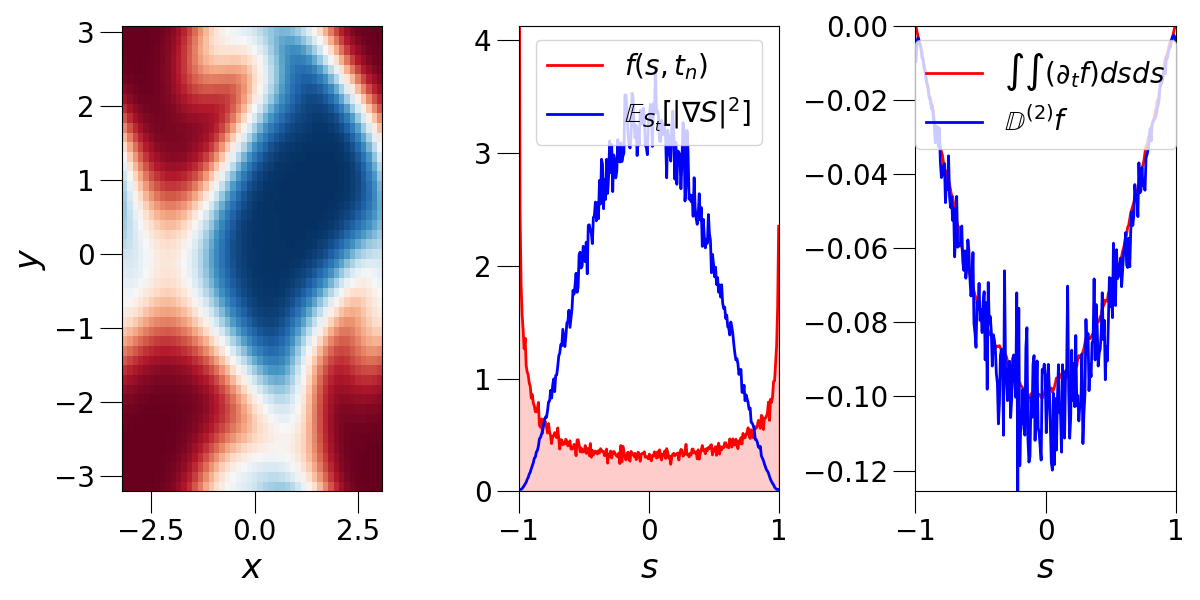

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


2024-04-18 14:06:23,425 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode


INFO:matplotlib.mathtext:Substituting symbol D from STIXGeneral


2024-04-18 14:06:23,483 matplotlib.mathtext 0/1 INFO :: Substituting symbol D from STIXGeneral


In [ ]:
import matplotlib as mpl
mpl.rcParams['xtick.major.size'] = 16
mpl.rcParams['ytick.major.size'] = 16

import matplotlib.pyplot as plt
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": "Helvetica",
#     'text.latex.preamble': r'\usepackage{amsfonts}'
# })
%matplotlib widget

fig, axs = plt.subplots(1,3,figsize=(12,6))

axs[0].pcolormesh(x_data,y_data,S_data[-1,:,:,0],cmap='RdBu',norm='linear')
axs[0].set_ylabel(r'$y$',fontsize=24)
axs[0].set_xlabel(r'$x$',fontsize=24)

axs[1].plot(s,f_S,'r', linewidth=2,label=r'$f(s,t_n)$')
axs[1].fill_between(x=s,y1=f_S,color= "r",alpha= 0.2)
axs[1].plot(s,E  ,'b', linewidth=2,label=r'$\mathbb{E}_{S_t}[|\nabla S|^2]$')

axs[1].set_xlabel(r'$s$',fontsize=24)
axs[1].set_xlim([-1,1])
axs[1].set_ylim([0.,1.1*np.max(E)])
axs[1].legend(loc=9,fontsize=20)

LHS = np.linalg.solve(L,dfdt)
RHS = D*f_S
axs[2].plot(s,LHS,'r', linewidth=2,label=r'$ \int \int (\partial_t f) dsds$')
axs[2].plot(s,RHS,'b', linewidth=2,label=r'$\mathbb{D}^{(2)} f$')
axs[2].set_xlabel(r'$s$',fontsize=24)
axs[2].set_xlim([-1,1])
axs[2].set_ylim([np.min(RHS),0.0])
axs[2].legend(loc=9,fontsize=20)

for n,ax in enumerate(axs):
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

plt.tight_layout()
plt.savefig('ABC_Flow.png',dpi=200)
plt.show()